In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [3]:
ri = pd.read_csv('data/doprava_maloobchod_sluzby.csv', encoding='utf-8') # industrial production index

In [7]:
ri['cznace_txt'] = ri['cznace_txt'].str.replace('\xa0', ' ')
print(ri['cznace_txt'].unique())

['Maloobchod (vč.maloobchodního prodeje pohonných hmot) a prodej a opravy motorových vozidel'
 'Maloobchod, kromě motorových vozidel' 'Maloobchod s potravinami'
 'Maloobchod s pohonnými hmotami ve specializovaných prodejnách'
 'Maloobchod s počítačovým a komunikačním zařízením ve specializovaných prodejnách'
 'Maloobchod mimo prodejny, stánky a trhy'
 'Maloobchod s nepotravinářským zbožím'
 'Maloobchod v nespecializovaných prodejnách'
 'Maloobchod s ostatními výrobky převážně pro domácnost ve specializovaných prodejnách'
 'Opravy a údržba motorových vozidel, kromě motocyklů'
 'Maloobchod s potravinami, nápoji a tabákovými výrobky ve specializovaných prodejnách'
 'Maloobchod s výrobky pro kulturní rozhled a rekreaci ve specializovaných prodejnách'
 'Maloobchod s ostatním zbožím ve specializovaných prodejnách'
 'Velkoobchod, maloobchod a opravy motorových vozidel'
 'Obchod s motorovými vozidly; obchod, opravy a údržba motocyklů'
 'Maloobchod s převahou potravin, nápojů a tabákových výrob

In [219]:
def get_data(nace, casz, oceneni, ocisteni):
    data = ri[ri['cznace_txt'] == nace]
    data = data[data['casz_txt'] == casz]
    data = data[data['oceneni_txt'] == oceneni]
    data = data[data['ocisteni_txt'] == ocisteni]
    return data.copy()

In [222]:
letani_bazicky = get_data('Letecká doprava', 'průměr bazického roku', 'běžné ceny', 'neočištěno')
letani_clean = get_data('Letecká doprava', 'průměr bazického roku', 'běžné ceny', 'sezónně očištěno, včetně očištění o kalendářní vlivy')

In [223]:
def plot_line(dataset, figname, short_timeframe=False, legend = None):
    colors = ["#00BDB1", "#EE5383", "#D69653", "#00ABDF"]
    fig, ax = plt.subplots()
    dataset = dataset.copy()

    for i, data in enumerate(dataset):
        if short_timeframe:
            data = data[data['rok'] >=2016].copy() 
            data = data[data['rok'] <= 2021].copy()

        print(data['rok'].unique())
        data.sort_values(['rok', 'mesic'], inplace=True)
        data['datum'] = data['mesic'].astype(str) + '/' + data['rok'].astype(str)

        ax.plot(data['datum'], data['hodnota'], color=colors[i])

    ax.tick_params(axis='x', labelrotation=45)
    # Generate custom x-tick positions for January and July
    ax.set_xticks([ '1/2016', '7/2016','1/2017', '7/2017','1/2018', '7/2018','1/2019', '7/2019', '1/2020', '7/2020', '1/2021', '7/2021'])
    ax.set_xticklabels([ '1/2016', '7/2016','1/2017', '7/2017','1/2018', '7/2018','1/2019', '7/2019', '1/2020', '7/2020', '1/2021', '7/2021'])

    ax.set_xlabel('Year')
    ax.set_ylabel('Revenue (% of base year(2021) average)')

    # Customize specific x-tick labels with different colors
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in ['1/2021', '7/2021']:
            tick_label.set_color('#EE5383')
            
    ax.grid(True, alpha=0.5, linestyle='--')
    #title:
    ax.set_title('Air transport revenue in Czechia')
    if len(dataset) > 1 and legend is not None:
        ax.legend(legend)
    #save to svg
    plt.tight_layout()
    plt.savefig(figname)

[2018 2019 2020 2021 2016 2017]


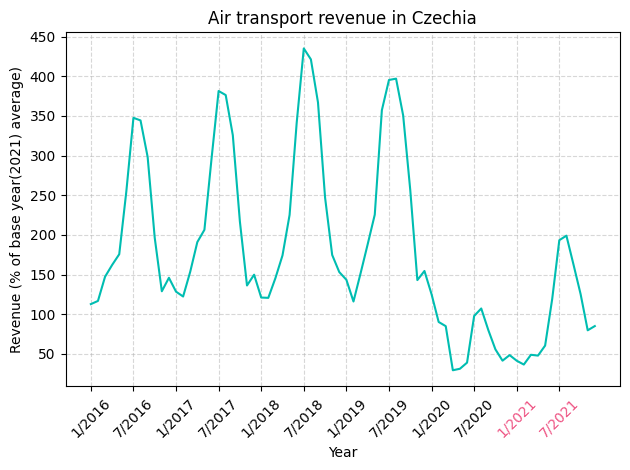

In [224]:
plot_line([letani_bazicky], figname='air_transport_seasonal.svg', short_timeframe=True)

In [225]:
def plot_decomposition(data):
    data['datum'] = data['mesic'].astype(str) + '/' + data['rok'].astype(str)
    #sort data:
    data = data.sort_values(['rok', 'mesic'])
    decomposition = seasonal_decompose(data['hodnota'], model='multiplicative', period=12)
    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(data['datum'], decomposition.observed, color="#EE5383")
    ax[0].set_title('Observed data')
    ax[0].set_ylim([0, 500])
    ax[1].plot(data['datum'], decomposition.trend, color="#EE5383")
    ax[1].set_title('Trend')
    ax[1].set_ylim([0, 500])
    ax[2].plot(data['datum'], decomposition.seasonal, color="#EE5383")
    ax[2].set_title('Seasonal')
    ax[2].set_ylim([0, 1.7])
    ax[3].plot(data['datum'], decomposition.resid, color="#EE5383")
    ax[3].set_title('Residual')
    ax[3].set_ylim([0, 1.7])

    for i in range(4):
        xticks = [f'1/{year}' for year in range(2000, 2025)]
        xtick_labels = [f'{year}' for year in range(2000, 2025)]
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xtick_labels)
        ax[i].tick_params(axis='x', labelrotation=45)
    
        for tick_label in ax[i].get_xticklabels():
            if tick_label.get_text() in ['2021']:
                tick_label.set_color('#EE5383')


    plt.tight_layout()
    plt.savefig('air_transport_decomposition.svg')

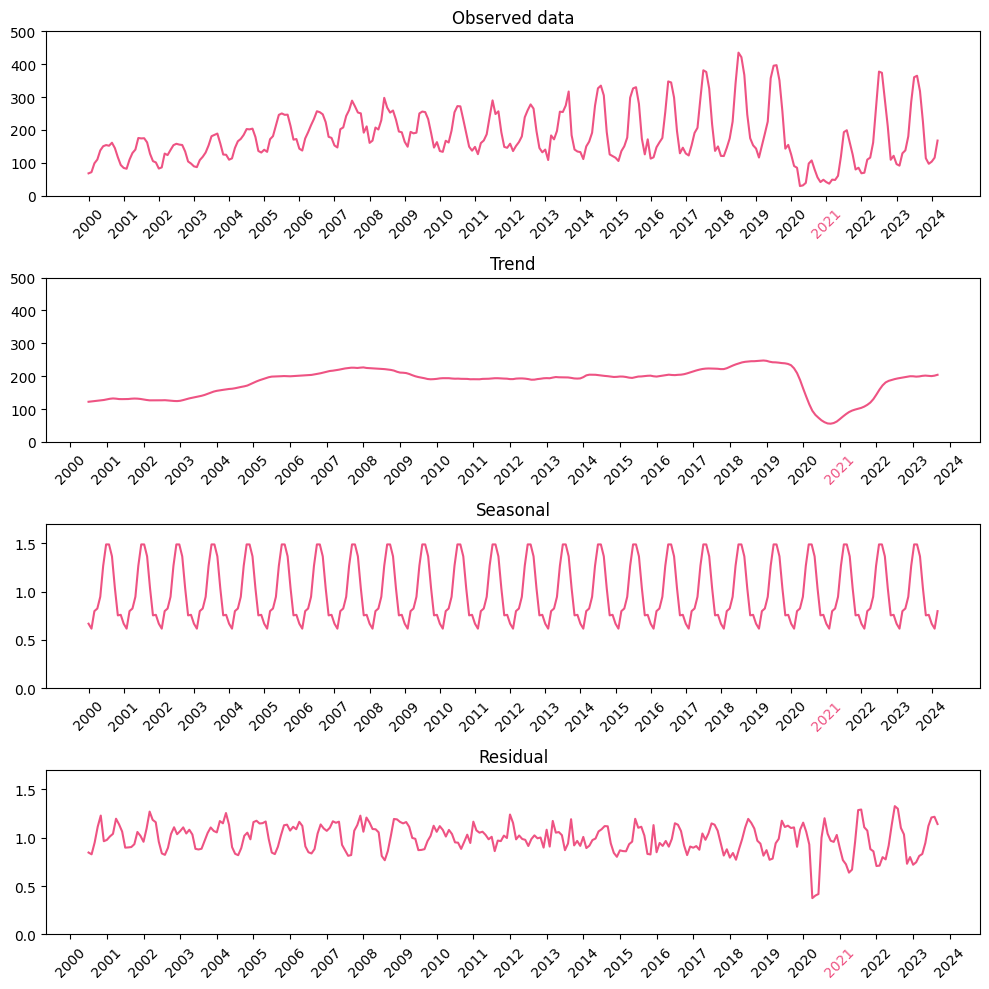

In [226]:
plot_decomposition(letani_bazicky)

In [229]:
letani_bazicky['datum'] = letani_bazicky['mesic'].astype(str) + '/' + letani_bazicky['rok'].astype(str)
letani_bazicky = letani_bazicky.sort_values(['rok', 'mesic'])
decomposition = seasonal_decompose(letani_bazicky['hodnota'], model='multiplicative', period=12)

In [230]:
letani_adjusted = letani_bazicky['hodnota'] / decomposition.seasonal

In [231]:
flights_adjusted = letani_bazicky.copy()
flights_adjusted['hodnota'] = letani_adjusted

[2016 2017 2018 2019 2020 2021]
[2016 2017 2018 2019 2020 2021]


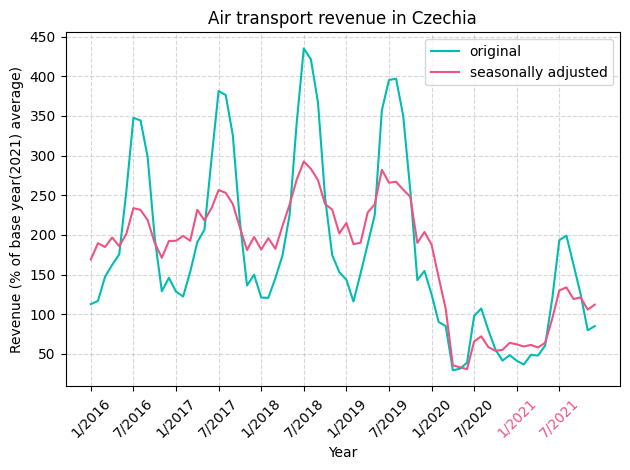

In [232]:
plot_line([letani_bazicky, flights_adjusted], figname='original_vs_seasonal_my.svg', short_timeframe=True, legend = ['original', 'seasonally adjusted'])

[2016 2017 2018 2019 2020 2021]
[2018 2019 2020 2021 2016 2017]


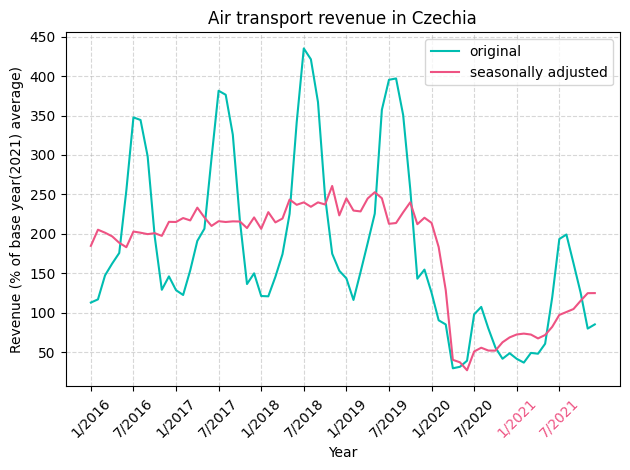

In [233]:
plot_line([letani_bazicky, letani_clean], figname='original_vs_seasonal_csu.svg', short_timeframe=True, legend = ['original', 'seasonally adjusted'])

Jakym odvetvim rostly trzby v obdobi covidu?

In [237]:
ri.head(2)

,idhod,hodnota,stapro_kod,casz_cis,casz_kod,cznace_cis,cznace_kod,oceneni_cis,oceneni_kod,ocisteni_cis,ocisteni_kod,mesic,rok,mesicz,rokz,stapro_txt,casz_txt,cznace_txt,oceneni_txt,ocisteni_txt
0,1263950915,93.8,1007,7626,C,5724,45470001,NaN,NaN,NaN,NaN,4,2010,4.0,2009,"Tržby z prodeje výrobků, služeb a zboží",stejné období předchozího roku,Maloobchod (vč.maloobchodního prodeje pohonnýc...,běžné ceny,neočištěno
1,1264321149,96.9,1007,7626,C,5104,47,NaN,NaN,NaN,NaN,4,2010,4.0,2009,"Tržby z prodeje výrobků, služeb a zboží",stejné období předchozího roku,"Maloobchod, kromě motorových vozidel",běžné ceny,neočištěno


In [239]:
covid_profitability = ri[ri['oceneni_txt'] == 'běžné ceny'][['hodnota','mesic', 'rok', 'cznace_txt', 'casz_txt', 'ocisteni_txt']].copy()

In [241]:
covid_profitability = covid_profitability[covid_profitability['casz_txt'] == 'stejné období předchozího roku']
covid_profitability = covid_profitability[covid_profitability['ocisteni_txt'] == 'sezónně očištěno, včetně očištění o kalendářní vlivy']

In [249]:
covid_df = covid_profitability.loc[(covid_profitability['rok'] >= 2019) & (covid_profitability['rok'] <= 2021)].copy()

In [250]:
covid_df.sort_values(['rok', 'mesic'], inplace=True)

In [257]:
covid_df_2020 = covid_df[covid_df['rok'] == 2020][['hodnota', 'mesic', 'cznace_txt']].copy()

In [261]:
covid_df_2019 = covid_df[covid_df['rok'] == 2019][['hodnota', 'mesic', 'cznace_txt']].copy()

In [258]:
average_hodnota = covid_df_2020.groupby('cznace_txt')['hodnota'].mean().reset_index()

In [260]:
average_hodnota.sort_values('hodnota', ascending=False)

,cznace_txt,hodnota
10,"Maloobchod mimo prodejny, stánky a trhy",124.416667
36,Poštovní a kurýrní činnosti,111.333333
6,Informační činnosti,107.266667
21,"Maloobchod s převahou potravin, nápojů a tabák...",104.733333
29,"Obchod, opravy a údržba motocyklů, jejich dílů...",104.641667
11,Maloobchod s farmaceutickými přípravky a maloo...,104.566667
23,Maloobchod v nespecializovaných prodejnách,104.150000
49,Vydavatelské činnosti,103.850000
16,Maloobchod s ostatními výrobky převážně pro do...,103.666667
18,Maloobchod s potravinami,103.583333


In [265]:
average_hodnota['hodnota'] = average_hodnota['hodnota'] - 100

In [268]:
average_hodnota.sort_values('hodnota', ascending=False, inplace=True)

In [270]:
average_hodnota.head(5)

,cznace_txt,hodnota
10,"Maloobchod mimo prodejny, stánky a trhy",24.416667
36,Poštovní a kurýrní činnosti,11.333333
6,Informační činnosti,7.266667
21,"Maloobchod s převahou potravin, nápojů a tabák...",4.733333
29,"Obchod, opravy a údržba motocyklů, jejich dílů...",4.641667


In [314]:
worst_5.cznace_txt.unique()

array(['Vodní doprava', 'Ubytování, stravování a pohostinství',
       'Ubytování', 'Letecká doprava',
       'Činnosti cestovních agentur, kanceláří a jiné rezervační a související činnosti'],
      dtype=object)

In [319]:
translation_eng = {
    'Maloobchod mimo prodejny, stánky a trhy': 'Retail trade, except of shops, stalls and markets',
    'Poštovní a kurýrní činnosti': 'Postal and courier activities',
    'Informační činnosti': 'Information services',
    'Maloobchod s převahou potravin, nápojů a tabákových výrobků v nespecializovaných prodejnách': 'Retail sale in non-specialized stores\n with food, beverages or tobacco predominating',
    'Obchod, opravy a údržba motocyklů, jejich dílů a příslušenství' : 'Sale, maintenance and repair of motorcycles \nand their parts and accessories',
    'Vodní doprava' : 'Water transport',
    'Ubytování, stravování a pohostinství' : 'Accommodation and food service activities',
    'Ubytování' : 'Accommodation',
    'Letecká doprava': 'Air transport',
    'Činnosti cestovních agentur, kanceláří a jiné rezervační a související činnosti' : 'Travel agency, tour operator and other \nreservation service and related activities',
}

In [320]:
average_hodnota['engnace_txt'] = average_hodnota['cznace_txt'].map(translation_eng)

In [321]:
top_5 = average_hodnota.head(5).copy()
worst_5 = average_hodnota.tail(5).copy()

In [328]:
top_5

,cznace_txt,hodnota,engnace_txt
10,"Maloobchod mimo prodejny, stánky a trhy",24.416667,"Retail trade, except of shops, stalls and markets"
36,Poštovní a kurýrní činnosti,11.333333,Postal and courier activities
6,Informační činnosti,7.266667,Information services
21,"Maloobchod s převahou potravin, nápojů a tabák...",4.733333,Retail sale in non-specialized stores\n with f...
29,"Obchod, opravy a údržba motocyklů, jejich dílů...",4.641667,"Sale, maintenance and repair of motorcycles \n..."


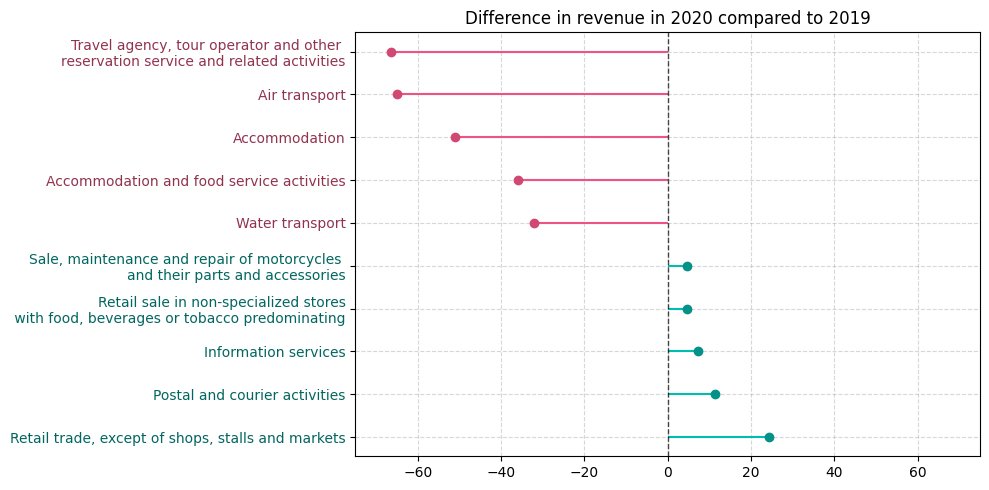

In [353]:
my_range=range(1,10+1)
#concat top5 and worst5 texts:
all = pd.concat([top_5, worst_5])

fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)

ax.hlines(y=range(1,6), xmin=0, xmax=top_5['hodnota'], color="#00BDB1")
ax.hlines(y=range(6,11), xmin=0, xmax=worst_5['hodnota'], color="#EE5383")

ax.plot(top_5['hodnota'], range(1,6), "o", color="#039188")
ax.plot(worst_5['hodnota'], range(6,11), "o", color="#D14972")
ax.set_xlim(-75, 75)
ax.axvline(x = 0, color = 'black', linewidth = 1, linestyle = '--', alpha = 0.7)

ax.set_yticks(range(1,6), top_5['engnace_txt'], color='#026660')
ax.set_yticks(range(6,11), worst_5['engnace_txt'], color='#91334F')

ax.set_yticks(my_range)
ax.set_yticklabels(all['engnace_txt'])

# Modify properties of individual y-tick labels
for i, label in enumerate(ax.get_yticklabels()):
    if i < 5:  # First 5 ticks (top 5)
        label.set_color('#026660')
    else:  # Last 5 ticks (worst 5)
        label.set_color('#91334F')

#fig.tight_layout()
ax.grid(True, alpha=0.5, linestyle='--')
plt.title('Difference in revenue in 2020 compared to 2019')
plt.savefig('top5_worst5_revenue.svg')

In [262]:
average_hodnota_2019 = covid_df_2019.groupby('cznace_txt')['hodnota'].mean().reset_index()

In [369]:
average_hodnota_2019['hodnota'] = average_hodnota_2019['hodnota'] - 100

In [370]:
top_5_2019 = top_5.join(average_hodnota_2019.set_index('cznace_txt'), on='cznace_txt', rsuffix='_2019')
worst_5_2019 = worst_5.join(average_hodnota_2019.set_index('cznace_txt'), on='cznace_txt', rsuffix='_2019')

In [375]:
worst_5_2019

,cznace_txt,hodnota,engnace_txt,hodnota_2019
48,Vodní doprava,-32.016667,Water transport,17.250000
46,"Ubytování, stravování a pohostinství",-35.900000,Accommodation and food service activities,5.000000
45,Ubytování,-51.175000,Accommodation,1.841667
7,Letecká doprava,-64.983333,Air transport,0.075000
51,"Činnosti cestovních agentur, kanceláří a jiné ...",-66.483333,"Travel agency, tour operator and other \nreser...",5.308333


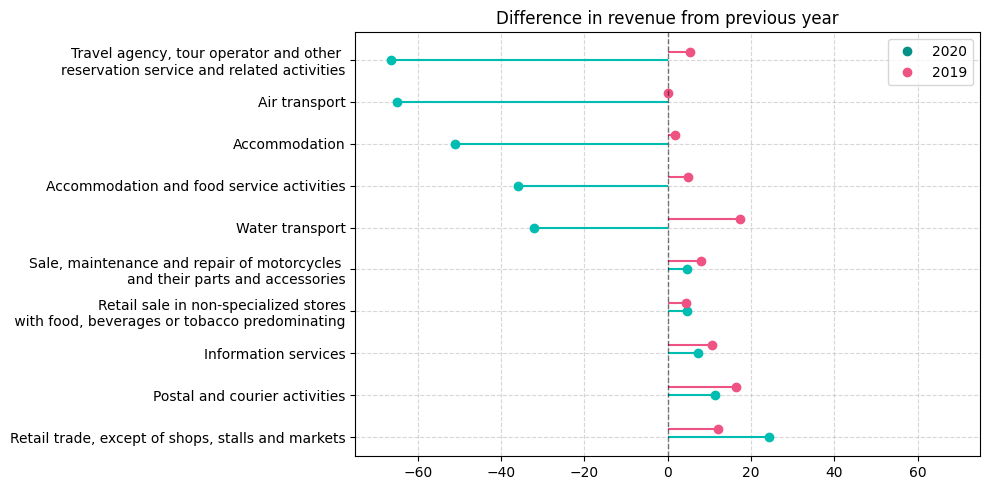

In [391]:
my_range=range(1,10+1)
#concat top5 and worst5 texts:
all = pd.concat([top_5, worst_5])

fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)

ax.hlines(y=range(1,6), xmin=0, xmax=top_5_2019['hodnota'], color="#00BDB1")
range_vals_1 = [1.2, 2.2, 3.2, 4.2, 5.2]
ax.hlines(y=range_vals_1, xmin=0, xmax=top_5_2019['hodnota_2019'], color="#EE5383")

ax.hlines(y=range(6,11), xmin=0, xmax=worst_5_2019['hodnota'], color="#00BDB1")
range_vals_2 = [6.2, 7.2, 8.2, 9.2, 10.2]
ax.hlines(y=range_vals_2, xmin=0, xmax=worst_5_2019['hodnota_2019'], color="#EE5383")


ax.plot(top_5_2019['hodnota'], range(1,6), "o", color="#00BDB1")
ax.plot(top_5_2019['hodnota_2019'], range_vals_1, "o", color="#EE5383")

ax.plot(worst_5_2019['hodnota'], range(6,11), "o", color="#00BDB1")
ax.plot(worst_5_2019['hodnota_2019'], range_vals_2, "o", color="#EE5383")

ax.set_xlim(-75, 75)
ax.axvline(x = 0, color = 'black', linewidth = 1, linestyle = '--', alpha = 0.5)

ax.set_yticks(range(1,6), top_5['engnace_txt'], color='#026660')
ax.set_yticks(range(6,11), worst_5['engnace_txt'], color='#91334F')

ax.set_yticks(my_range)
ax.set_yticklabels(all['engnace_txt'], color='black')


#add legend:
ax.plot([], [], 'o', color="#039188", label='2020')
ax.plot([], [], 'o', color="#EE5383", label='2019')
ax.legend()


#fig.tight_layout()
ax.grid(True, alpha=0.5, linestyle='--')
plt.title('Difference in revenue from previous year')
plt.savefig('top5_worst5_2019_added.svg')

In [281]:
fig, ax = plt.subplots()

TypeError: cannot unpack non-iterable Axes object